# House Prices Prediction

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the House Prices dataset made available for this competition.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

## Import the library

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

2025-08-28 08:45:29.314076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756379729.326567   68445 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756379729.330187   68445 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756379729.341028   68445 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756379729.341048   68445 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756379729.341049   68445 computation_placer.cc:177] computation placer alr

## Load the dataset


In [2]:
# Initializing train dataset
train_file = "train.csv"
train_df = pd.read_csv(train_file)
print("Full train dataset shape is {}".format(train_df.shape))

# Dropping ID column from train dataset
train_df = train_df.drop('Id', axis=1)


# Initializing test dataset

test_file_path = "test.csv"
test_df = pd.read_csv(test_file_path)
print(f"Test dataset shape: {test_df.shape}")

# Stores test IDs

test_ids = test_df['Id']

# Dropping ID column from test dataset
test_df = test_df.drop('Id', axis=1)

Full train dataset shape is (1460, 81)
Test dataset shape: (1459, 80)


The data is composed of 81 columns and 1460 entries. We can see all 81 dimensions of our dataset by printing out the first 3 entries using the following code:

In [3]:
train_df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


* There are 79 feature columns. Using these features your model has to predict the house sale price indicated by the label column named `SalePrice`.

We will drop the `Id` column as it is not necessary for model training.

We can inspect the types of feature columns using the following code:

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [5]:
print("Types of data:\n")
print(train_df.dtypes.value_counts())

Types of data:

object     43
int64      34
float64     3
Name: count, dtype: int64


## House Price Distribution Visualization

Now let us take a look at how the house prices are distributed.

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


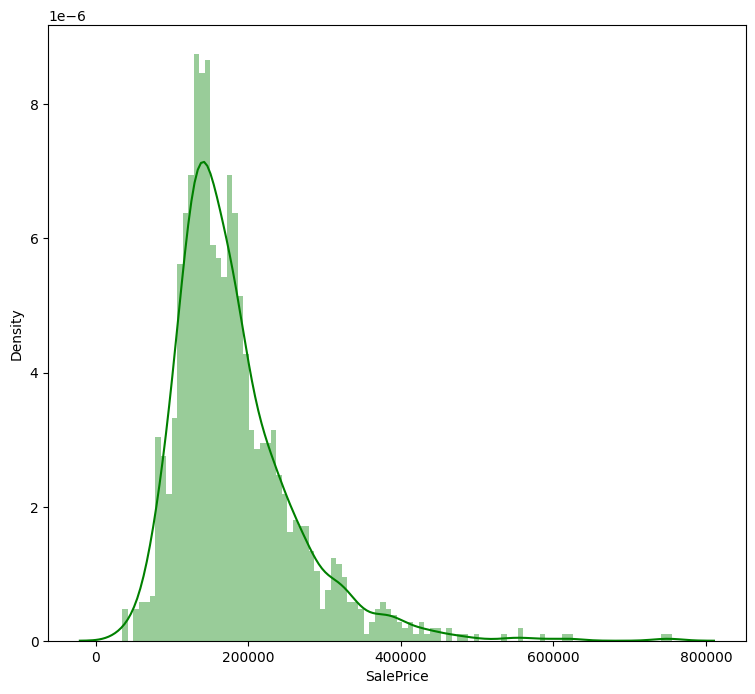

In [6]:
print(train_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(train_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

## Numerical Data Distribution Visualization

We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones.

In [7]:
list(set(train_df.dtypes.tolist()))

[dtype('float64'), dtype('O'), dtype('int64')]

In [8]:
df_num = train_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


Now let us plot the distribution for all the numerical features.

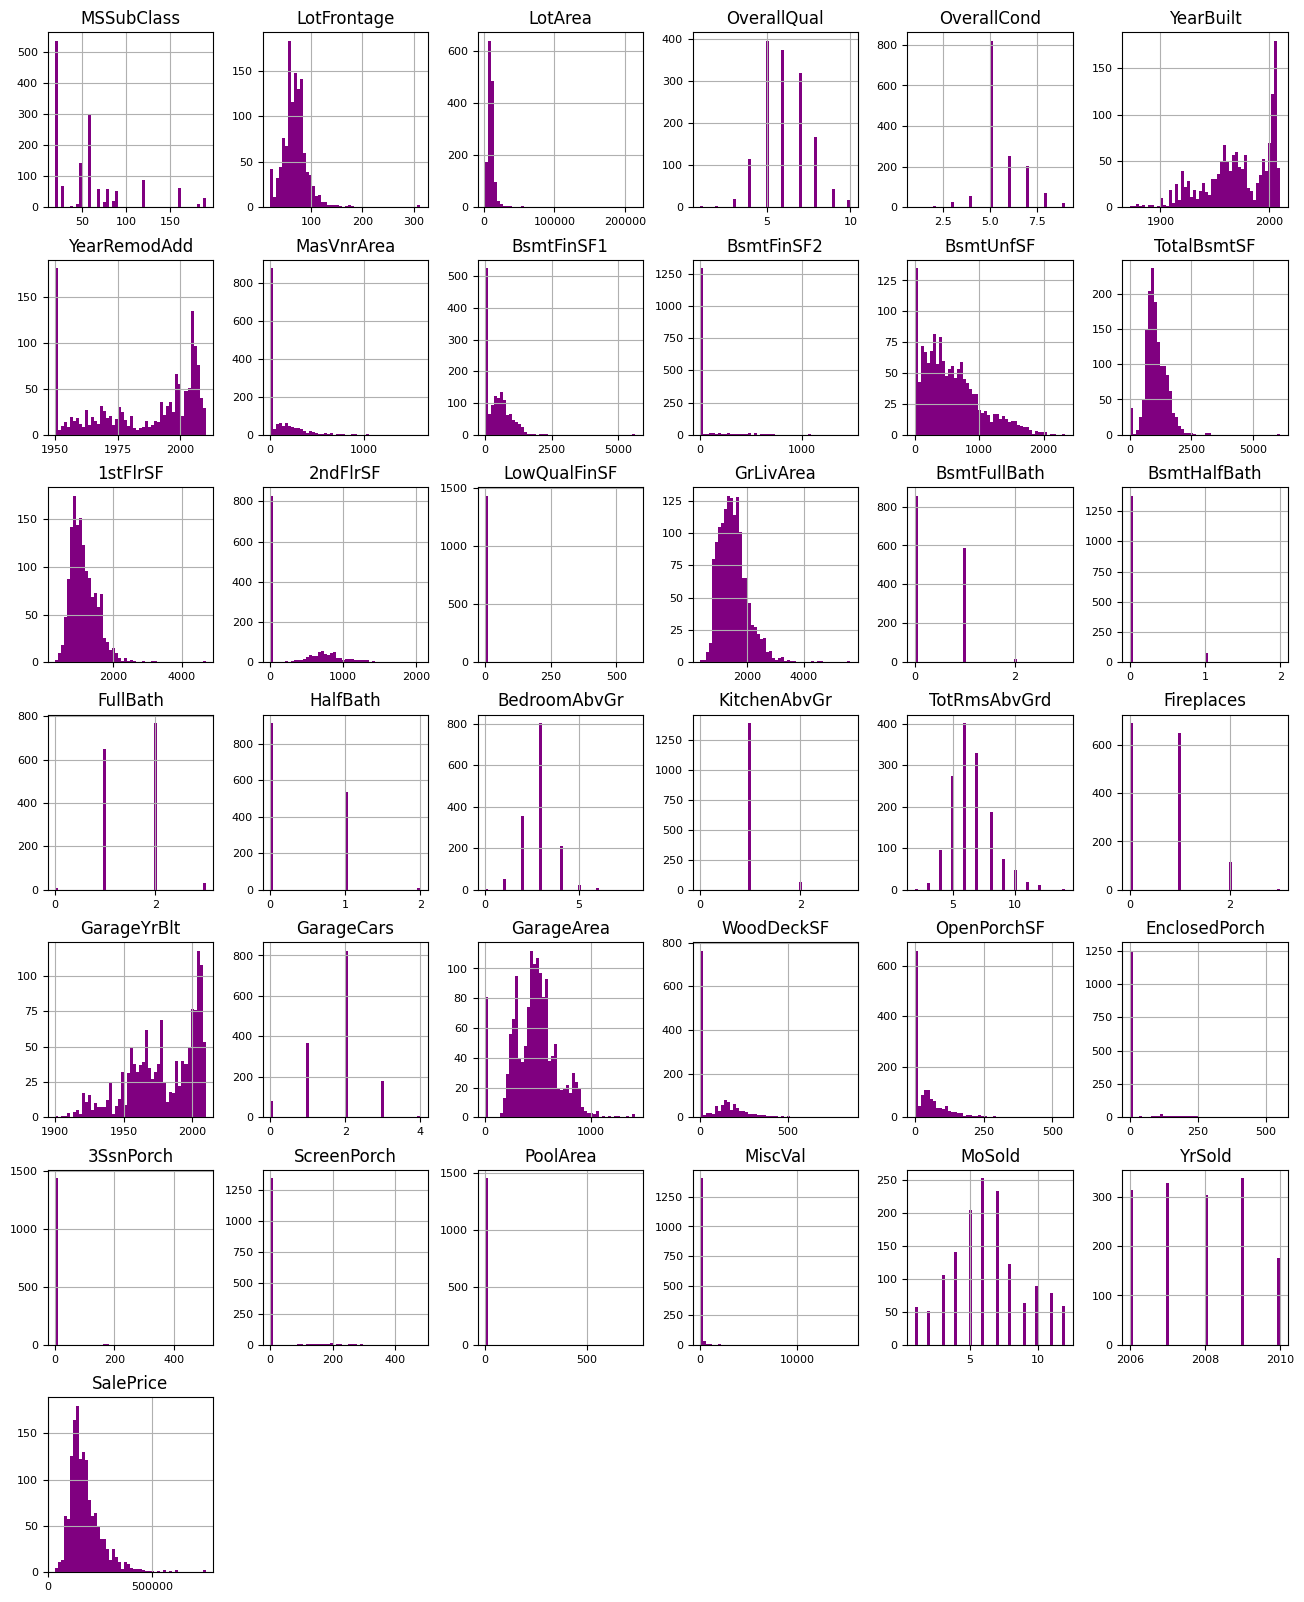

In [9]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8, color= 'purple');

## Missing Values Visualization

In [10]:
print("Missing values in each column")
missing_data = train_df.isnull().sum()
print(missing_data[missing_data > 0].sort_values(ascending=False))

Missing values in each column
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


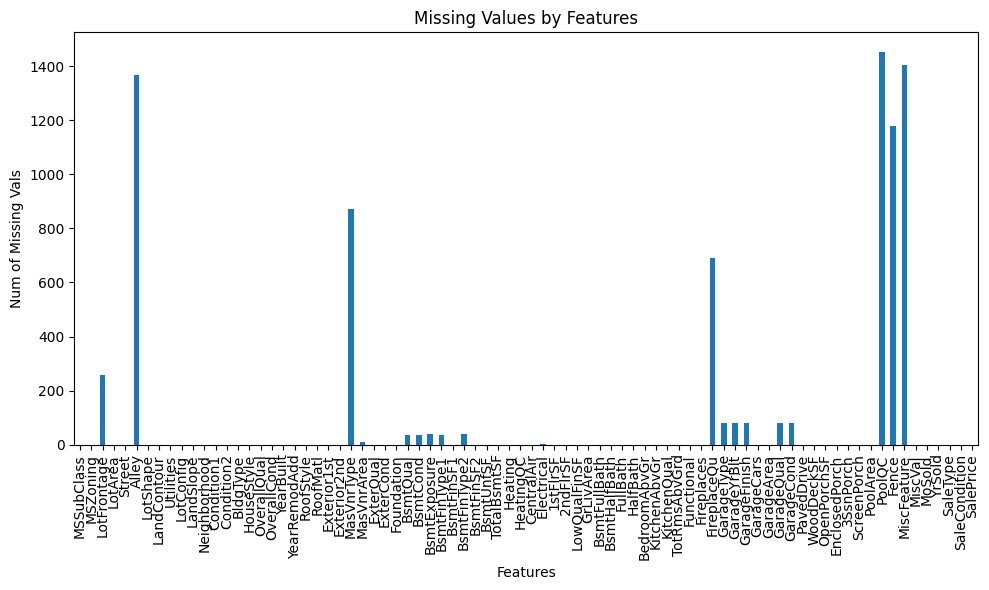

In [11]:
# Visualizing the missing values

plt.figure(figsize=(10, 6))
missing_data.plot(kind="bar")
plt.title("Missing Values by Features")
plt.xlabel("Features")
plt.ylabel("Num of Missing Vals")
plt.tight_layout()
plt.show()

## Correlation With SalePrice Visualization

In [12]:
# Finding coorelation between numerical features (int & float) with target feature (SalePrice)
numerical_features = train_df.select_dtypes(include= [np.number]).columns.tolist()

correlation = train_df[numerical_features].corr()['SalePrice'].sort_values(ascending=False)
print(f"Top 10 correlated features:\n{correlation.head(10)}")

Top 10 correlated features:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


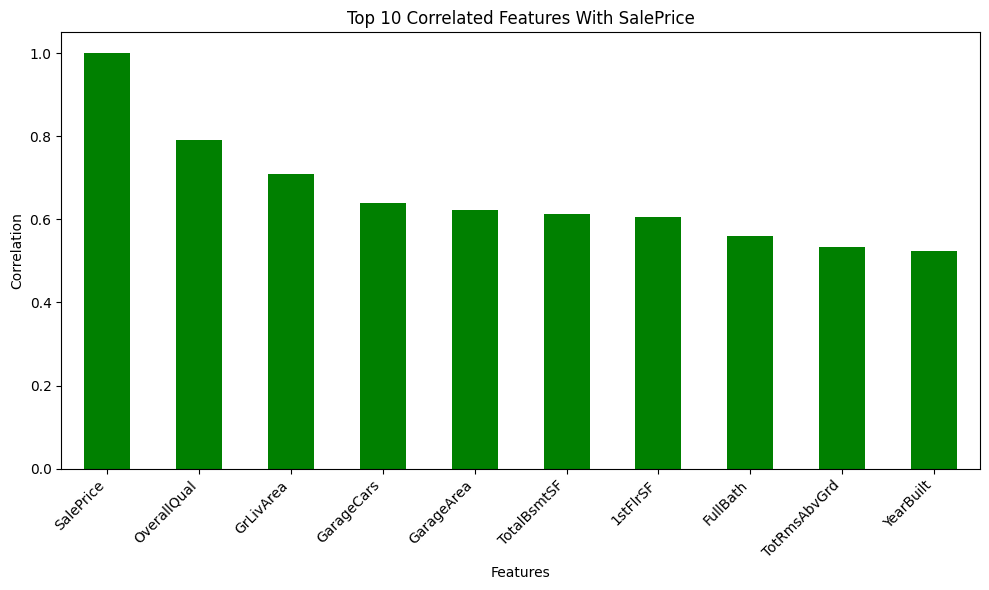

In [13]:
# Visualizing the correlation features with SalePrice

plt.figure(figsize=(10, 6))
correlation.head(10).plot(kind="bar", color= 'green')
plt.title("Top 10 Correlated Features With SalePrice")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()

## Data Cleaning

In [14]:
def clean_data(train_df, test_df):

    for df in [train_df, test_df]:
        
        # Filling LotsFrontage missing data with mean value
        if 'LotFrontage' in train_df.columns:
            df['LotFrontage'] = df['LotFrontage'].fillna(train_df['LotFrontage'].mean())
    
        # Filling BsmtFinType2 missing data with mode value (due to skewness)
        if 'BsmtFinType2' in df.columns:
            df['BsmtFinType2'] = df['BsmtFinType2'].fillna(train_df['BsmtFinType2'].mode()[0])
    
        # Filling BsmtFinType1 missing data with mode value (due to skewness)
        if 'BsmtFinType1' in df.columns:
            df['BsmtFinType1'] = df['BsmtFinType1'].fillna(train_df['BsmtFinType1'].mode()[0])
    
        # Removing Alley
        if 'Alley' in df.columns: 
            df.drop(['Alley'], axis = 1, inplace = True)
    
        # Filling MasVnrType missing data with modal value
        if 'MasVnrType' in df.columns:
            df['MasVnrType'] = df['MasVnrType'].fillna(train_df['MasVnrType'].mode()[0])
    
        # Filling MasVnrArea missing data with modal value
        if 'MasVnrArea' in df.columns:
            df['MasVnrArea'] = df['MasVnrArea'].fillna(train_df['MasVnrArea'].mode()[0])
    
        # Filling GarageQual missing data with modal value
        if 'GarageQual' in df.columns:
            df['GarageQual'] = df['GarageQual'].fillna(train_df['GarageQual'].mode()[0])
    
        # Filling missing data in BsmtCond with modal values
        if 'BsmtCond' in df.columns:
            df['BsmtCond'] = df['BsmtCond'].fillna(train_df['BsmtCond'].mode()[0])
    
        # Filling missing data in Electrical with modal values
        if 'Electrical' in df.columns:
            df['Electrical'] = df['Electrical'].fillna(train_df['Electrical'].mode()[0])
    
        # Filling missing data in BsmtQual with modal values
        if 'BsmtQual' in df.columns:
            df['BsmtQual'] = df['BsmtQual'].fillna(train_df['BsmtQual'].mode()[0])
    
        # Removing GarageYrBlt
        if 'GarageYrBlt' in df.columns:
            df.drop(['GarageYrBlt'], axis = 1, inplace = True)
    
        # Filling missing data in FireplaceQu with modal values
        if 'FireplaceQu' in df.columns:
            df['FireplaceQu'] = df['FireplaceQu'].fillna(train_df['FireplaceQu'].mode()[0])
    
        # Filling missing data in GarageType with modal values
        if 'GarageType' in df.columns:
            df['GarageType'] = df['GarageType'].fillna(train_df['GarageType'].mode()[0])
    
        # Filling missing data in GarageFinish with modal values
        if 'GarageFinish' in df.columns:
            df['GarageFinish'] = df['GarageFinish'].fillna(train_df['GarageFinish'].mode()[0])
    
        # Filling missing data in GarageCond with modal values
        if 'GarageCond' in df.columns:
            df['GarageCond'] = df['GarageCond'].fillna(train_df['GarageCond'].mode()[0])
    
        # Filling missing data in GarageCond with modal values
        if 'BsmtExposure' in df.columns:
            df['BsmtExposure'] = df['BsmtExposure'].fillna(train_df['BsmtExposure'].mode()[0])
    
        df.drop(['PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)
    
        # For Test Dataset:
        
        # Filling missing data in BsmtHalfBath with modal values
        if 'BsmtHalfBath' in df.columns:
            df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(train_df['BsmtHalfBath'].mode()[0])
    
        # Filling missing data in BsmtFullBath with modal values
        if 'BsmtFullBath' in df.columns:
            df['BsmtFullBath'] = df['BsmtFullBath'].fillna(train_df['BsmtFullBath'].mode()[0])
    
        # Filling missing data in BsmtFinSF1 with modal values
        if 'BsmtFinSF1' in df.columns:
            df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(train_df['BsmtFinSF1'].mode()[0])
    
        # Filling missing data in BsmtFinSF2 with modal values
        if 'BsmtFinSF2' in df.columns:
            df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(train_df['BsmtFinSF2'].mode()[0])
    
        # Filling missing data in TotalBsmtSF with modal values
        if 'TotalBsmtSF' in df.columns:
            df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(train_df['TotalBsmtSF'].mode()[0])
    
        # Filling missing data in BsmtUnfSF with modal values
        if 'BsmtUnfSF' in df.columns:
            df['BsmtUnfSF'] = df['BsmtUnfSF'].fillna(train_df['BsmtUnfSF'].mode()[0])
    
        # Filling missing data in GarageCars with modal values
        if 'GarageCars' in df.columns:
            df['GarageCars'] = df['GarageCars'].fillna(train_df['GarageCars'].mode()[0])
    
        # Filling missing data in GarageArea with modal values
        if 'GarageArea' in df.columns:
            df['GarageArea'] = df['GarageArea'].fillna(train_df['GarageArea'].mode()[0])
    
    return train_df, test_df

In [15]:
#  Preprocessing training dataset

train_processed, test_processed = clean_data(train_df, test_df)

In [16]:
# Processed datasets info for comparison

train_processed.info(), test_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

(None, None)

In [17]:
# Revising missing data in each column for the processed dataset

missing_data = train_processed.isnull().sum()
print(missing_data[missing_data > 0].sort_values(ascending=False))

Series([], dtype: int64)


# Data Preprocessing

In [18]:
# Handling Categorical Feature

categorical_columns = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
                      'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                      'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
                      'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
                      'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                      'PavedDrive', 'SaleType', 'SaleCondition']


label_encoders = {}
le = LabelEncoder()
scaler = StandardScaler()

# LabelEncoder converts categorical columns to numerical representation
for field in categorical_columns:
    if field != 'SalePrice':
        
        # Fit on combined data to ensure consistent encoding
        combined_values = pd.concat([train_processed[field], test_processed[field]], axis=0)
        le.fit(combined_values)
        
        train_processed[field] = le.transform(train_processed[field])
        test_processed[field] = le.transform(test_processed[field])
        
        label_encoders[field] = le

# Feature Scaling: Transforms dataset so they have a mean of 0 and a standard deviation of 1

scaler.fit(train_processed[categorical_columns])
train_processed[categorical_columns] = scaler.transform(train_processed[categorical_columns])
test_processed[categorical_columns] = scaler.transform(test_processed[categorical_columns])
        
        

print("Data preprocessing completed...")

Data preprocessing completed...


In [19]:
# Re-processed datasets info for comparison

train_processed.info(), test_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   float64
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   float64
 5   LotShape       1460 non-null   float64
 6   LandContour    1460 non-null   float64
 7   Utilities      1460 non-null   float64
 8   LotConfig      1460 non-null   float64
 9   LandSlope      1460 non-null   float64
 10  Neighborhood   1460 non-null   float64
 11  Condition1     1460 non-null   float64
 12  Condition2     1460 non-null   float64
 13  BldgType       1460 non-null   float64
 14  HouseStyle     1460 non-null   float64
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

(None, None)

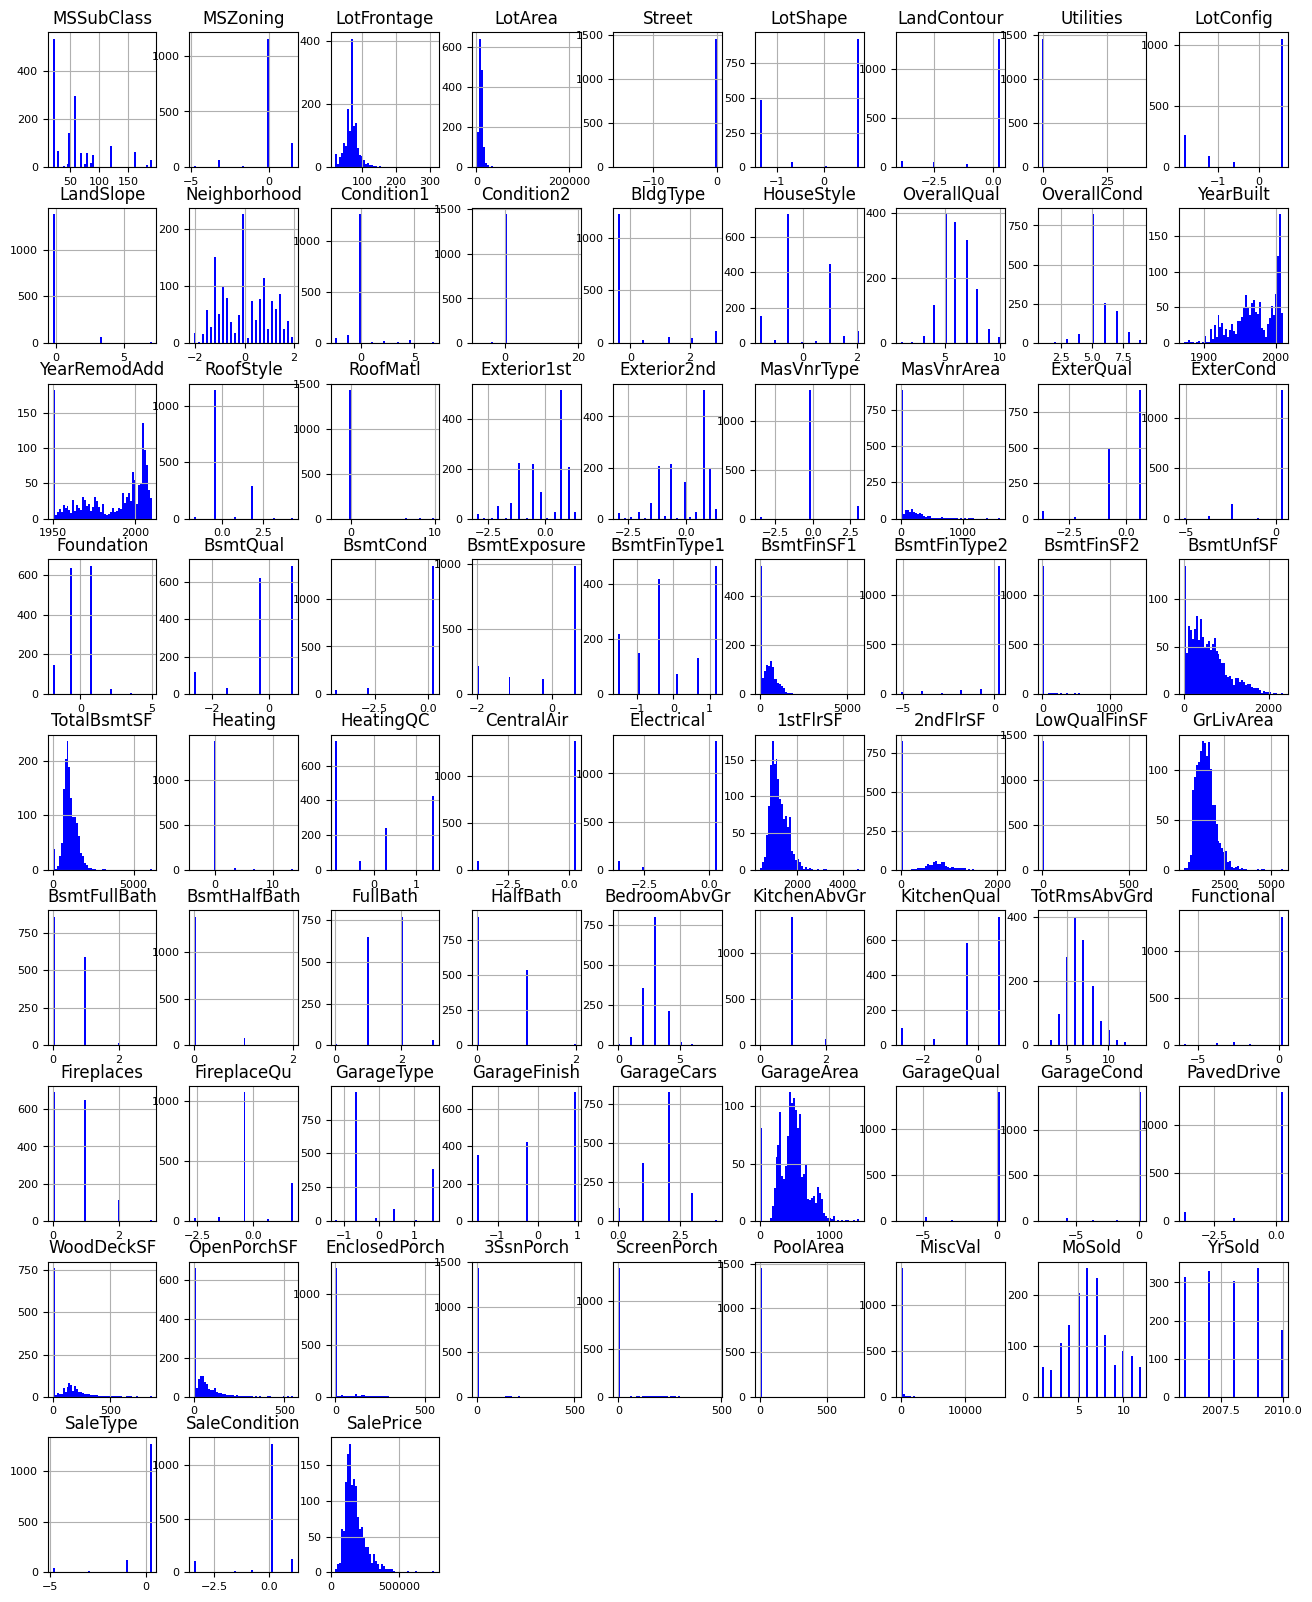

In [20]:
train_processed.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8, color= 'blue');

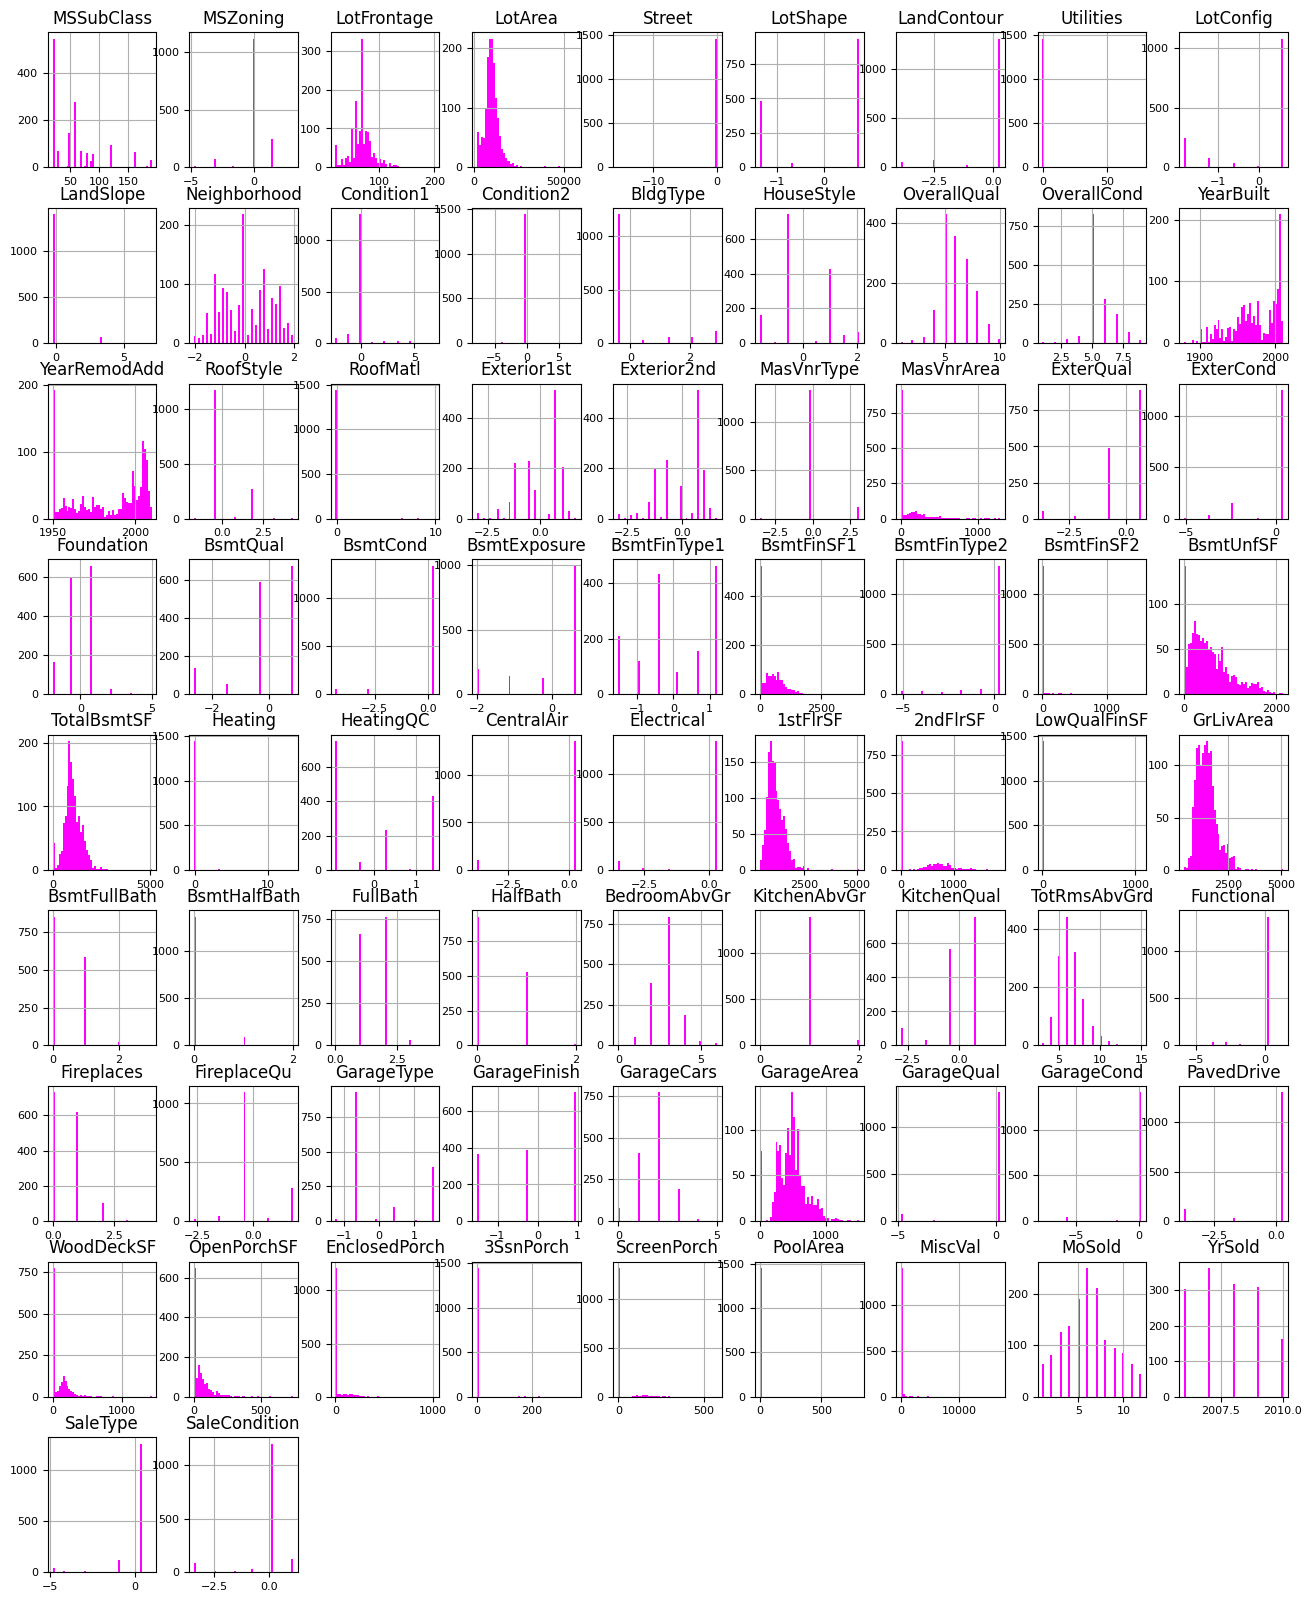

In [21]:
test_processed.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8, color= 'magenta');

## Prepare the dataset

This dataset contains a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models, making them a great entry point to Tensorflow and ML.

In [22]:
# Revising missing data in each column for the processed dataset

missing_data = test_processed.isnull().sum()
print(missing_data[missing_data > 0].sort_values(ascending=False))

Series([], dtype: int64)


In [23]:
# Checking datasets shapes

print("Train dataset shape is {}".format(train_processed.shape))
print("Test dataset shape is {}".format(test_processed.shape))

Train dataset shape is (1460, 75)
Test dataset shape is (1459, 74)


# Using Scikit-learn

In [24]:
# Prepare descriptive features and target features
desc_feat = train_processed.drop('SalePrice', axis=1)
targ_feat = train_processed['SalePrice']

Now let us split the dataset into training and testing datasets:

In [25]:
# Function for train-test-split (80:20)

d_train, d_val, t_train, t_val = train_test_split(desc_feat, targ_feat, test_size=0.2, random_state=23)

In [26]:
def rmse_score(t_true, t_pred):
    """Calculates Root Mean Squared Error (RMSE)"""
    return math.sqrt(mean_squared_error(t_true, t_pred))

## Training Bottomline Models

### Random Forest Bottom Line Model

In [35]:
# Random Forest model
rf_bl = RandomForestRegressor()

In [36]:
print("Training Random Forest model...")
rf_bl.fit(d_train, t_train)

Training Random Forest model...


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [37]:
# Validating model

rf_bl_preds = rf_bl.predict(d_val)
rf_bl_rmse = rmse_score(t_val, rf_bl_preds)

#### Feature importance analysis

In [38]:
feature_importance = pd.DataFrame({'feature': desc_feat.columns,'importance': rf_bl.feature_importances_}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features for RF Bottomline Model:")
print(feature_importance.head(10))


Top 10 Most Important Features for RF Bottomline Model:
         feature  importance
15   OverallQual    0.587057
44     GrLivArea    0.114990
36   TotalBsmtSF    0.037922
42      2ndFlrSF    0.033528
32    BsmtFinSF1    0.025559
41      1stFlrSF    0.022069
59    GarageArea    0.012698
17     YearBuilt    0.011827
52  TotRmsAbvGrd    0.011361
3        LotArea    0.011348


### K-Nearest Neighbors Bottom Line Model

In [39]:
# k-NN bottomline model

knn_bl = KNeighborsRegressor()
knn_bl.fit(d_train, t_train)
knn_val_preds = knn_bl.predict(d_val)
knn_bl_rmse = rmse_score(t_val, knn_val_preds)

### Support Vector Machine Bottom Line Model

In [40]:
# SVM bottomline model

svm_bl = SVR()
svm_bl.fit(d_train, t_train)
svm_bl_preds = svm_bl.predict(d_val)
svm_bl_rmse = rmse_score(t_val, svm_bl_preds)

### Gradient Boosting Bottom Line Model

In [41]:
# XGBoost bottomline model

xgb_bl = xgb.XGBRegressor(objective='reg:squarederror')
xgb_bl.fit(d_train, t_train)
xgb_bl_preds = xgb_bl.predict(d_val)
xgb_bl_rmse = np.sqrt(mean_squared_error(t_val, xgb_bl_preds))

### Bottom Line Model Evaluation

In [42]:
bottomline_models = {
    'Random Forest': rf_bl_rmse,
    'k-NN': knn_bl_rmse,
    'SVM': svm_bl_rmse,
    'XGBoost': xgb_bl_rmse
}

print("Bottomline Results:")
for model, score in bottomline_models.items():
    print(f"{model}: {score:.2f} RMSE")

Bottomline Results:
Random Forest: 22538.42 RMSE
k-NN: 36848.02 RMSE
SVM: 72022.11 RMSE
XGBoost: 22695.19 RMSE


## Training Fine Tuned Models

### Random Forest Fine Tuned Model

In [43]:
# Random Forest Hyperparameter tuning

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# Random Forest Hyperparameter tuning (For RandomizedSearchCV)

rf_params_rs = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'bootstrap': [True, False],
    'max_features': ['sqrt', 'log2', None]
}

In [44]:
# Setting up GridSearch Cross Validation

# rf_grid = GridSearchCV(
#     RandomForestRegressor(random_state=42), 
#     rf_params, 
#     cv=3,
#     verbose= 1
#     scoring='neg_mean_squared_error',
#     n_jobs=-1
# )

# Setting up RandomizedSearch Cross Validation
rf_grid = RandomizedSearchCV(
    RandomForestRegressor(random_state=3), 
    rf_params_rs,
    n_iter= 50,
    cv=3,
    verbose= 1,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Training the fine tuned model

rf_grid.fit(d_train, t_train)

# Finding the best params

rf_best = rf_grid.best_estimator_

# Setting up and training fine tuned model

rf_tuned_preds = rf_best.predict(d_val)
rf_tuned_rmse = rmse_score(t_val, rf_tuned_preds)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


### k-NN Fine Tuned Model

In [45]:
# k-NN Hyperparameter tuning

knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# k-NN Hyperparameter tuning (For RandomizedSearchCV)

knn_params_rs = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2, 3],  # For Minkowski distance
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [46]:
# Setting up GridSearch Cross Validation

# knn_grid = GridSearchCV(
#     KNeighborsRegressor(), 
#     knn_params, 
#     cv=3,
#     verbose= 1,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1
# )

# Setting up RandomizedSearch Cross Validation

knn_grid = RandomizedSearchCV(
    KNeighborsRegressor(), 
    knn_params_rs, 
    n_iter= 30,
    cv=3,
    verbose= 1,
    random_state= 3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Training the fine tuned model

knn_grid.fit(d_train, t_train)

# Finding the best params

knn_best = knn_grid.best_estimator_

# Setting up and training fine tuned model

knn_tuned_preds = knn_best.predict(d_val)
knn_tuned_rmse = rmse_score(t_val, knn_tuned_preds)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


### SVM Fine Tuned Model

In [47]:
# SVM Hyperparameter tuning

svm_params = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

# SVM Hyperparameter tuning (For RandomizedSearchCV)

svm_params_rs = {
    'kernel': ['rbf'],
    'C': uniform(0.1, 5),
    'epsilon': uniform(0.01, 0.2),
    'gamma': ['scale', 'auto'],
}

In [48]:
# Setting up GridSearch Cross Validation

# svm_grid = GridSearchCV(
#     SVR(), 
#     svm_params, 
#     cv=3,
#     verbose= 1,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1
# )

# Setting up RandomizedSearch Cross Validation

svm_grid = RandomizedSearchCV(
    SVR(), 
    svm_params_rs,
    n_iter= 10,
    random_state= 3,
    cv=2,
    verbose= 1,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Training the fine tuned model

svm_grid.fit(d_train, t_train)

# Finding the best params

svm_best = svm_grid.best_estimator_

# Setting up and training fine tuned model

svm_tuned_preds = svm_best.predict(d_val)
svm_tuned_rmse = rmse_score(t_val, svm_tuned_preds)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


### Gradient Boosting Fine Tuned Model

In [49]:
# XGBoost learning parameter tuning

lr = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2]
}

xgb_lr = xgb.XGBRegressor(
    n_estimators=100,
    random_state=3,
    objective='reg:squarederror'
)

# Learning Rate tuning (For RandomizedSearchCV)

xgb_params_rs = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.6, 0.4),  # Between 0.6 and 1.0
    'colsample_bytree': uniform(0.6, 0.4),
    'learning_rate': uniform(0.01, 0.29),  # Between 0.01 and 0.3
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

In [50]:
# Setting up GridSearch Cross Validation

# xgb_gridcv = GridSearchCV(
#     estimator=xgb_lr,
#     param_grid=lr,
#     cv=3,
#     scoring='neg_mean_squared_error',
#     verbose=1,
#     n_jobs=-1
# )

# SVM Hyperparameter tuning (For RandomizedSearchCV)

xgb_gridcv = RandomizedSearchCV(
    xgb.XGBRegressor(
        random_state= 3,
        objective='reg:squarederror',
        tree_method='hist'
    ),
    xgb_params_rs,
    n_iter= 50,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Training the fine tuned model

xgb_gridcv.fit(d_train, t_train)

# Finding the best params

xgb_best = xgb_gridcv.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [51]:
# Setting up and training fine tuned model

xgb_tuned_preds = xgb_best.predict(d_val)
xgb_tuned_rmse = rmse_score(t_val, xgb_tuned_preds)

### Fine Tuned Model Evaluation

In [52]:
tuned_models = {
    'Random Forest': rf_tuned_rmse,
    'k-NN': knn_tuned_rmse,
    'SVM': svm_tuned_rmse,
    'XGBoost': xgb_tuned_rmse
    
}

print("Fine-tuned Results:")
for model, score in tuned_models.items():
    print(f"{model}: {score:.2f} RMSE")

Fine-tuned Results:
Random Forest: 22285.70 RMSE
k-NN: 33032.30 RMSE
SVM: 71979.07 RMSE
XGBoost: 19772.88 RMSE


# Using TensorFlow

In [53]:
train_set = pd.concat([d_train, t_train], axis= 1)
test_set = pd.concat([d_val, t_val], axis= 1)

In [54]:
print(f"Comparing Split shapes:")
print(f"Sklearn - Train: {d_train.shape}, Val: {d_val.shape}")
print(f"TensorFlow - Train: {train_set.shape}, Val: {test_set.shape}")

Comparing Split shapes:
Sklearn - Train: (1168, 74), Val: (292, 74)
TensorFlow - Train: (1168, 75), Val: (292, 75)


In [55]:
# Preparing TensorFlow datasets

ds_train = tfdf.keras.pd_dataframe_to_tf_dataset(train_set, label="SalePrice", task= tfdf.keras.Task.REGRESSION)

ds_val   = tfdf.keras.pd_dataframe_to_tf_dataset(test_set,   label="SalePrice", task= tfdf.keras.Task.REGRESSION)

I0000 00:00:1756379901.694951   68445 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 766 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


## Training Bottomline Models

### Random Forest Bottomline Model

In [56]:
# Bottomline RandomForest Model

rf_bltf  = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)

# Training the bottomline model

rf_bltf.fit(ds_train)

# Producing prediction

rf_bltf_pred = np.squeeze(rf_bltf.predict(ds_val))

Use /tmp/tmp4y0mmlm3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.662196. Found 1168 examples.
Training model...


I0000 00:00:1756379905.909863   68445 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1756379905.909898   68445 kernel.cc:783] Collect training examples
I0000 00:00:1756379905.909906   68445 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1756379905.910247   68445 kernel.cc:401] Number of batches: 2
I0000 00:00:1756379905.910253   68445 kernel.cc:402] Number of examples: 1168
I0000 00:00:1756379905.910751   68445 kernel.cc:802] Training dataset:
Number of records: 1168
Number of columns: 75

Number of columns by type:
	NUMERICAL: 75 (100%)

Columns:

NUMERICAL: 75 (100%)
	0: "1stFlrSF" NUMERICAL mean:1163.69 min:334 max:4692 sd:399.45
	1: "2ndFlrSF" NUMERICAL mean:361.026 min:0 max:2065 sd:443.866
	2: 

Model trained in 0:00:00.593538
Compiling model...


I0000 00:00:1756379906.467099   68445 decision_forest.cc:808] Model loaded with 300 root(s), 110896 node(s), and 72 input feature(s).
I0000 00:00:1756379906.470302   68445 abstract_model.cc:1439] Engine "RandomForestOptPred" built
2025-08-28 08:48:26.470332: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 73ms/step


In [57]:
# Saves true values of target feature

y_true = test_set['SalePrice'].to_numpy()

In [58]:
# Calculating RMSE

rf_bltf_rmse = np.sqrt(mean_squared_error(y_true, rf_bltf_pred))

### Gradient Boosting Bottomline Model

In [59]:
# Bottomline Gradient Boosting Model

gb_bltf  = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.REGRESSION)

# Training the bottomline model

gb_bltf.fit(ds_train)

# Producing prediction

gb_bltf_pred = np.squeeze(gb_bltf.predict(ds_val))

# Calculating RMSE

gb_bltf_rmse = np.sqrt(mean_squared_error(y_true, gb_bltf_pred))

Use /tmp/tmpcyck4l4m as temporary training directory
Reading training dataset...


W0000 00:00:1756379907.487045   68445 gradient_boosted_trees.cc:1873] "goss_alpha" set but "sampling_method" not equal to "GOSS".
W0000 00:00:1756379907.487062   68445 gradient_boosted_trees.cc:1883] "goss_beta" set but "sampling_method" not equal to "GOSS".
W0000 00:00:1756379907.487064   68445 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.438394. Found 1168 examples.
Training model...


I0000 00:00:1756379907.932583   68445 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1756379907.932614   68445 kernel.cc:783] Collect training examples
I0000 00:00:1756379907.932622   68445 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1756379907.932764   68445 kernel.cc:401] Number of batches: 2
I0000 00:00:1756379907.932769   68445 kernel.cc:402] Number of examples: 1168
I0000 00:00:1756379907.933219   68445 kernel.cc:802] Training dataset:
Number of records: 1168
Number of columns: 75

Number of columns by type:
	NUMERICAL: 75 (100%)

Columns:

NUMERICAL: 75 (100%)
	0: "1stFlrSF" NUMERICAL mean:1163.69 min:334 max:4692 sd:399.45
	1: "2ndFlrSF" NUMERICAL mean:361.026 min:0 max:2065 sd:443.866
	2: 

Model trained in 0:00:00.321493
Compiling model...


I0000 00:00:1756379908.231023   69851 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 20746.1
I0000 00:00:1756379908.231049   69851 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 113
I0000 00:00:1756379908.234603   69851 gradient_boosted_trees.cc:279] Truncates the model to 84 tree(s) i.e. 84  iteration(s).
I0000 00:00:1756379908.234841   69851 gradient_boosted_trees.cc:341] Final model num-trees:84 valid-loss:20746.140625 valid-rmse:20746.140625
I0000 00:00:1756379908.236827   69851 kernel.cc:926] Export model in log directory: /tmp/tmpcyck4l4m with prefix 7a07f08847534360
I0000 00:00:1756379908.238631   69851 kernel.cc:944] Save model in resources
I0000 00:00:1756379908.240155   68445 abstract_model.cc:921] Model self evaluation:
Number of predictions (with weights): 1
Task: REGRESSION
Loss (SQUARED_ERROR): 20746.1

RMSE: 144.035
Default RMSE: : 0

2025-08-28 08:48:28.245460: I t

Model compiled.
1/1 [==============================] - 0s 62ms/step


### Bottomline Model Evaluation

In [60]:
bottomline_models_tf = {
    'Random Forest (TF)': rf_bltf_rmse,
    'Gradient Boosting (TF)': gb_bltf_rmse
}

print("Bottomline Results:")
for model, score in bottomline_models_tf.items():
    print(f"{model}: {score:.2f} RMSE")

Bottomline Results:
Random Forest (TF): 22056.48 RMSE
Gradient Boosting (TF): 20653.13 RMSE


## Training Fine Tuned Models

### RandomForest Fine Tuned Model

In [61]:
# Fine Tuned Random Forest Model

rf_tunedtf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, num_trees=500, max_depth=16, min_examples=2)

# Training the fine tuned model

rf_tunedtf.fit(ds_train)

# Producing prediction

rf_tunedtf_pred = np.squeeze(rf_tunedtf.predict(ds_val))

# Calculating RMSE

rf_tunedtf_rmse = np.sqrt(mean_squared_error(y_true, rf_tunedtf_pred))

Use /tmp/tmp91iq4tpw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.433327. Found 1168 examples.
Training model...


I0000 00:00:1756379910.442342   68445 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1756379910.442361   68445 kernel.cc:783] Collect training examples
I0000 00:00:1756379910.442368   68445 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1756379910.442519   68445 kernel.cc:401] Number of batches: 2
I0000 00:00:1756379910.442525   68445 kernel.cc:402] Number of examples: 1168
I0000 00:00:1756379910.442983   68445 kernel.cc:802] Training dataset:
Number of records: 1168
Number of columns: 75

Number of columns by type:
	NUMERICAL: 75 (100%)

Columns:

NUMERICAL: 75 (100%)
	0: "1stFlrSF" NUMERICAL mean:1163.69 min:334 max:4692 sd:399.45
	1: "2ndFlrSF" NUMERICAL mean:361.026 min:0 max:2065 sd:443.866
	2: 

Model trained in 0:00:01.728363
Compiling model...


I0000 00:00:1756379912.132306   68445 decision_forest.cc:808] Model loaded with 500 root(s), 425006 node(s), and 73 input feature(s).
2025-08-28 08:48:32.132352: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


Model compiled.


1/1 [==============================] - 0s 76ms/step


In [62]:
# Fine Tuned Gradient Boosting Model

gb_tunedtf = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.REGRESSION, num_trees=1_000, max_depth=8, shrinkage=0.05, subsample=0.7)

# Training the fine tuned model

gb_tunedtf.fit(ds_train)

# Producing prediction

gb_tunedtf_pred = np.squeeze(gb_tunedtf.predict(ds_val))

# Calculating RMSE

gb_tunedtf_rmse = np.sqrt(mean_squared_error(y_true, gb_tunedtf_pred))

Use /tmp/tmpxst5sdr9 as temporary training directory
Reading training dataset...


W0000 00:00:1756379912.640206   68445 gradient_boosted_trees.cc:1873] "goss_alpha" set but "sampling_method" not equal to "GOSS".
W0000 00:00:1756379912.640255   68445 gradient_boosted_trees.cc:1883] "goss_beta" set but "sampling_method" not equal to "GOSS".
W0000 00:00:1756379912.640257   68445 gradient_boosted_trees.cc:1897] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.441231. Found 1168 examples.
Training model...


I0000 00:00:1756379913.091193   68445 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1756379913.091215   68445 kernel.cc:783] Collect training examples
I0000 00:00:1756379913.091221   68445 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1756379913.091414   68445 kernel.cc:401] Number of batches: 2
I0000 00:00:1756379913.091423   68445 kernel.cc:402] Number of examples: 1168
I0000 00:00:1756379913.091882   68445 kernel.cc:802] Training dataset:
Number of records: 1168
Number of columns: 75

Number of columns by type:
	NUMERICAL: 75 (100%)

Columns:

NUMERICAL: 75 (100%)
	0: "1stFlrSF" NUMERICAL mean:1163.69 min:334 max:4692 sd:399.45
	1: "2ndFlrSF" NUMERICAL mean:361.026 min:0 max:2065 sd:443.866
	2: 

Model trained in 0:00:00.923884
Compiling model...


I0000 00:00:1756379913.969483   71914 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 18403.1
I0000 00:00:1756379913.969507   71914 gradient_boosted_trees.cc:1669] Create final snapshot of the model at iteration 236
I0000 00:00:1756379913.979104   71914 gradient_boosted_trees.cc:279] Truncates the model to 207 tree(s) i.e. 207  iteration(s).
I0000 00:00:1756379913.979211   71914 gradient_boosted_trees.cc:341] Final model num-trees:207 valid-loss:18403.123047 valid-rmse:18403.123047
I0000 00:00:1756379913.984218   71914 kernel.cc:926] Export model in log directory: /tmp/tmpxst5sdr9 with prefix f4e76146e5d44705
I0000 00:00:1756379913.989737   71914 kernel.cc:944] Save model in resources
I0000 00:00:1756379913.991142   68445 abstract_model.cc:921] Model self evaluation:
Number of predictions (with weights): 1
Task: REGRESSION
Loss (SQUARED_ERROR): 18403.1

RMSE: 135.658
Default RMSE: : 0

2025-08-28 08:48:33.997120: 

Model compiled.
1/1 [==============================] - 0s 68ms/step


### Fine Tuned Model Evaluation

In [63]:
tuned_models_tf = {
    'Random Forest (TF)': rf_tunedtf_rmse,
    'Gradient Boosting (TF)': gb_tunedtf_rmse
}

print("Fine Tuned Results:")
for model, score in tuned_models_tf.items():
    print(f"{model}: {score:.2f} RMSE")

Fine Tuned Results:
Random Forest (TF): 21811.84 RMSE
Gradient Boosting (TF): 20253.40 RMSE


# Visual Comparison

In [64]:
comparison_data = []

for model in ['Random Forest', 'k-NN', 'SVM', 'XGBoost']:
    comparison_data.append({
        'Model': model,
        'Type': 'Bottomline',
        'RMSE': bottomline_models[model]
    })
    comparison_data.append({
        'Model': model,
        'Type': 'Fine-tuned',
        'RMSE': tuned_models[model]
    })

# Creating a comparison dataframe
comparison_df = pd.DataFrame(comparison_data)

for model in ['Random Forest (TF)', 'Gradient Boosting (TF)']:
    comparison_data.append({
        'Model': model,
        'Type': 'Bottomline',
        'RMSE': bottomline_models_tf[model]
    })
    comparison_data.append({
        'Model': model,
        'Type': 'Fine-tuned',
        'RMSE': tuned_models_tf[model]
    })

# Creating a comparison dataframe
comparison_df = pd.DataFrame(comparison_data)

In [65]:
comparison_df

,Model,Type,RMSE
0,Random Forest,Bottomline,22538.420627
1,Random Forest,Fine-tuned,22285.702913
2,k-NN,Bottomline,36848.015317
3,k-NN,Fine-tuned,33032.300925
4,SVM,Bottomline,72022.105931
5,SVM,Fine-tuned,71979.074369
6,XGBoost,Bottomline,22695.187860
7,XGBoost,Fine-tuned,19772.877585
8,Random Forest (TF),Bottomline,22056.478776
9,Random Forest (TF),Fine-tuned,21811.836786


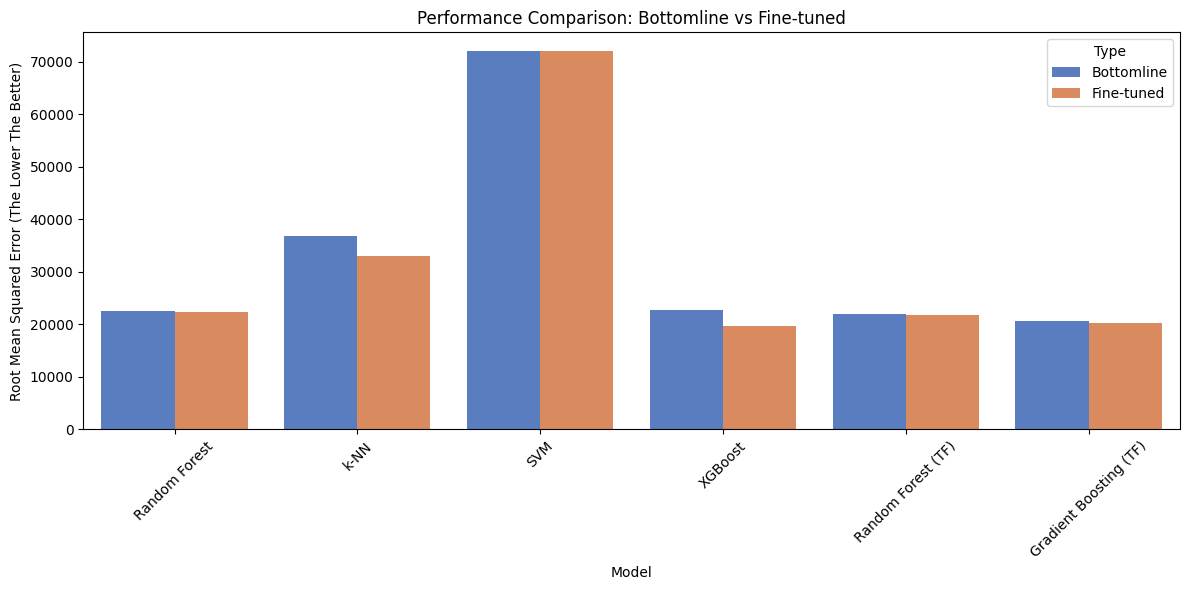

In [66]:
# Model Comparison

plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_df, x='Model', y='RMSE', hue='Type', palette='muted')
plt.title('Performance Comparison: Bottomline vs Fine-tuned')
plt.ylabel('Root Mean Squared Error (The Lower The Better)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Evaluating the best model

In [67]:
all_results = {**bottomline_models, **tuned_models, **bottomline_models_tf, **tuned_models_tf}
best_model_name = min(all_results, key=all_results.get)
best_rmse = all_results[best_model_name]

print(f"\nBest Model: {best_model_name} with RMSE: {best_rmse:.2f}")

# Generates test predictions with best model
if best_model_name == 'Random Forest':
    if rf_tuned_rmse < rf_bl_rmse:
        best_model = rf_best
        print("Using fine-tuned Random Forest")
    else:
        best_model = rf_bl
        print("Using baseline Random Forest")
elif best_model_name == 'k-NN':
    if knn_tuned_rmse < knn_bl_rmse:
        best_model = knn_best
        print("Using fine-tuned k-NN")
    else:
        best_model = knn_bl
        print("Using baseline k-NN")
elif best_model_name == 'XGBoost':
    if xgb_tuned_rmse < xgb_bl_rmse:
        best_model = xgb_best
        print("Using fine-tuned XGBoost")
    else:
        best_model = xgb_bl  # Fixed: was knn_bl
        print("Using baseline XGBoost")
elif best_model_name == 'Random Forest (TF)':
    if rf_tunedtf_rmse < rf_bltf_rmse:
        best_model = rf_tunedtf
        print("Using fine-tuned TF Random Forest")
    else:
        best_model = rf_bltf
        print("Using baseline TF Random Forest")
elif best_model_name == 'Gradient Boosting (TF)':
    if gb_tunedtf_rmse < gb_bltf_rmse:
        best_model = gb_tunedtf
        print("Using fine-tuned TF Gradient Boosting")
    else:
        best_model = gb_bltf
        print("Using baseline TF Gradient Boosting")
else:  # SVM
    if svm_tuned_rmse < svm_bl_rmse:
        best_model = svm_best
        print("Using fine-tuned SVM")
    else:
        best_model = svm_bl
        print("Using baseline SVM")

# Generates final predictions
if 'TF' in best_model_name:
    # For TensorFlow Decision Forests models, we need a tf.data.Dataset
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_processed, task=tfdf.keras.Task.REGRESSION)
    test_predictions = np.squeeze(best_model.predict(test_ds))
else:
    # For scikit-learn models
    test_predictions = best_model.predict(test_processed)


Best Model: XGBoost with RMSE: 19772.88
Using fine-tuned XGBoost


# Generating Prediction From Best Model

In [68]:
# Creates submission file
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': test_predictions
})

# Saves submission
submission.to_csv('house_prices_submission.csv', index=False)
print(f"\nPredictions saved to 'house_prices_submission.csv'")
print(f"Best model used: {best_model}")

# Feature importance for Random Forest (if it's the best model)
if 'Random Forest' in best_model_name and 'TF' not in best_model_name:
    # Only show feature importance for scikit-learn Random Forest (TF-DF doesn't have feature_importances_)
    feature_importance = pd.DataFrame({
        "feature": desc_feat.columns,
        "importance": best_model.feature_importances_
    }).sort_values("importance", ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

print(f"\nSubmission shape: {submission.shape}")
print("First few predictions:")
print(submission.head(5))


Predictions saved to 'house_prices_submission.csv'
Best model used: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.6473339845847362), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=np.float64(0.19231319546410514), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.09208487275022002), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=827, n_jobs=None,
             num_parallel_tree=None, ...)

Submission shape: (1459, 2)
First few predictions:
     Id      SalePrice
0  1461